In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import anndata as ad
import muon as mu
import scanpy as sc
import torch
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap.umap_ as umap # umap-learn

import cellij

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

# random seed to use throughout the notebook
seed = 123


/home/ubuntu/miniconda3/envs/cellij/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/miniconda3/envs/cellij/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/miniconda3/envs/cellij/lib/python3.10/site-packages/uma

In [3]:
mdata = cellij.core.Importer().load_Guo2010()

model = cellij.core.models.SimpleGP(
    n_factors=2
)

model.add_data(data=mdata)
model.add_covariate(mdata.obs[["division_scaled"]])
model.fit(
    likelihoods="Normal",
    epochs=10000,
    verbose_epochs=1000,
    learning_rate=0.01,
)


Using custom guide.
Epoch      0:           2.76 	


/home/ubuntu/projects/cellij/cellij/core/_gp.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducing_points=torch.tensor(
/home/ubuntu/miniconda3/envs/cellij/lib/python3.10/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'sigma_qPCR', 'w_qPCR'}
  warnings.warn(


Epoch   1000:         -17.15 	| 721.94%	|  21.27s
Epoch   2000:         -25.87 	| -50.84%	|  21.72s
Epoch   3000:         -32.59 	| -26.02%	|  21.46s
Epoch   4000:         -35.93 	| -10.24%	|  21.69s
Epoch   5000:         -43.03 	| -19.75%	|  21.22s
Epoch   6000:         -43.83 	|  -1.86%	|  21.74s
Epoch   7000:         -45.82 	|  -4.54%	|  21.58s
Epoch   8000:         -45.93 	|  -0.24%	|  21.28s
Epoch   9000:         -51.70 	| -12.56%	|  21.29s
Early stopping of training due to convergence at step 9110
Training finished.


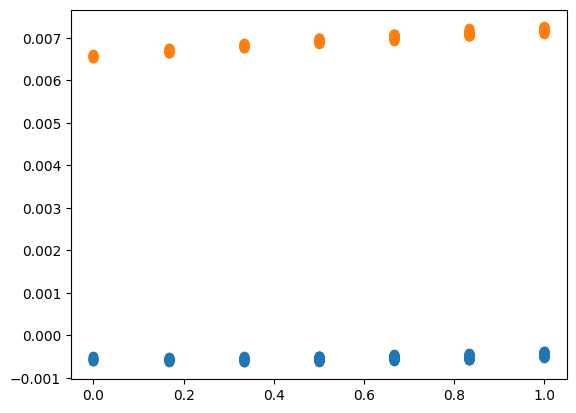

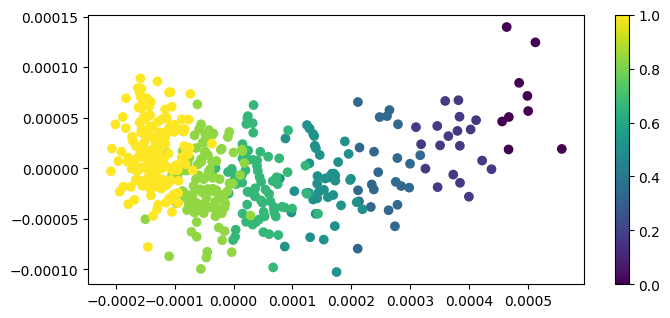

In [17]:
factor_means = []
with torch.no_grad():
    dist = model.gp(model.covariate)
    samples = dist(torch.Size([100000])).cpu()
    mean = samples.mean(dim=0)
    mean = torch.transpose(mean, -1, -2)
    factor_means.append(torch.transpose(mean, -1, -2))

factor_means = torch.stack(factor_means, dim=0)

for i in range(10):
    try:
        plt.scatter(model.covariate.cpu().detach().numpy(), factor_means.squeeze()[i], )
    except:
        pass
    
# umap_obj = umap.UMAP()
# result = umap_obj.fit_transform(factor_means.squeeze().T)

pca = PCA(n_components=2)
result = pca.fit_transform(factor_means.squeeze().T)

result = pd.DataFrame(result)
result["time"] = mdata.obs["division_scaled"].values
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8, 3.5))
s = axs.scatter(result[0], result[1], c = result["time"])
fig.colorbar(s, ax=axs)